In [65]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [66]:
# Load the dataset
ds = xr.open_dataset('../dat/RBC_Output.nc')

# Select two consecutive time steps (you can change the index)
time_idx = 50  # Middle of the simulation
X_init = ds.isel(time=time_idx)
X_target = ds.isel(time=time_idx + 1)

# Extract time information
dt = float((X_target.time - X_init.time) / np.timedelta64(1, 's'))
print(f"Time step size: {dt} seconds")

# Print data dimensions
print("\nData dimensions:")
for var in ['u', 'w', 'b', 'p_dyn']:
    if var in ds:
        print(f"{var}: {ds[var].shape}")

Time step size: 0.5 seconds

Data dimensions:
u: (201, 256, 256)
w: (201, 257, 256)
b: (201, 256, 256)
p_dyn: (201, 256, 256)


C:\Users\deban\AppData\Local\Temp\ipykernel_20600\1651897292.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('../dat/RBC_Output.nc')


In [67]:
def interpolate_to_common_grid(field, target_shape=(256, 256)):
    """Interpolate field to common grid (z_aac, x_caa)"""
    if field.shape == target_shape:
        return field
    
    # Use PyTorch for interpolation
    field_tensor = torch.from_numpy(field).float().unsqueeze(0).unsqueeze(0)
    interpolated = F.interpolate(field_tensor, size=target_shape, mode='bilinear', align_corners=True)
    return interpolated.squeeze().numpy()

# Extract fields from X_init
u_init = X_init['u'].values  # (z_aac, x_faa)
w_init = X_init['w'].values  # (z_aaf, x_caa)
b_init = X_init['b'].values  # (z_aac, x_caa)
p_dyn_init = X_init['p_dyn'].values  # (z_aac, x_caa)

# Extract target buoyancy (only for comparison, NOT for training)
b_target = X_target['b'].values

# Interpolate u and w to common grid
u_interp = interpolate_to_common_grid(u_init, (256, 256))
w_interp = interpolate_to_common_grid(w_init, (256, 256))

print("Original shapes:")
print(f"u: {u_init.shape}, w: {w_init.shape}")
print(f"b: {b_init.shape}, p_dyn: {p_dyn_init.shape}")
print("\nAfter interpolation:")
print(f"u: {u_interp.shape}, w: {w_interp.shape}")

Original shapes:
u: (256, 256), w: (257, 256)
b: (256, 256), p_dyn: (256, 256)

After interpolation:
u: (256, 256), w: (256, 256)


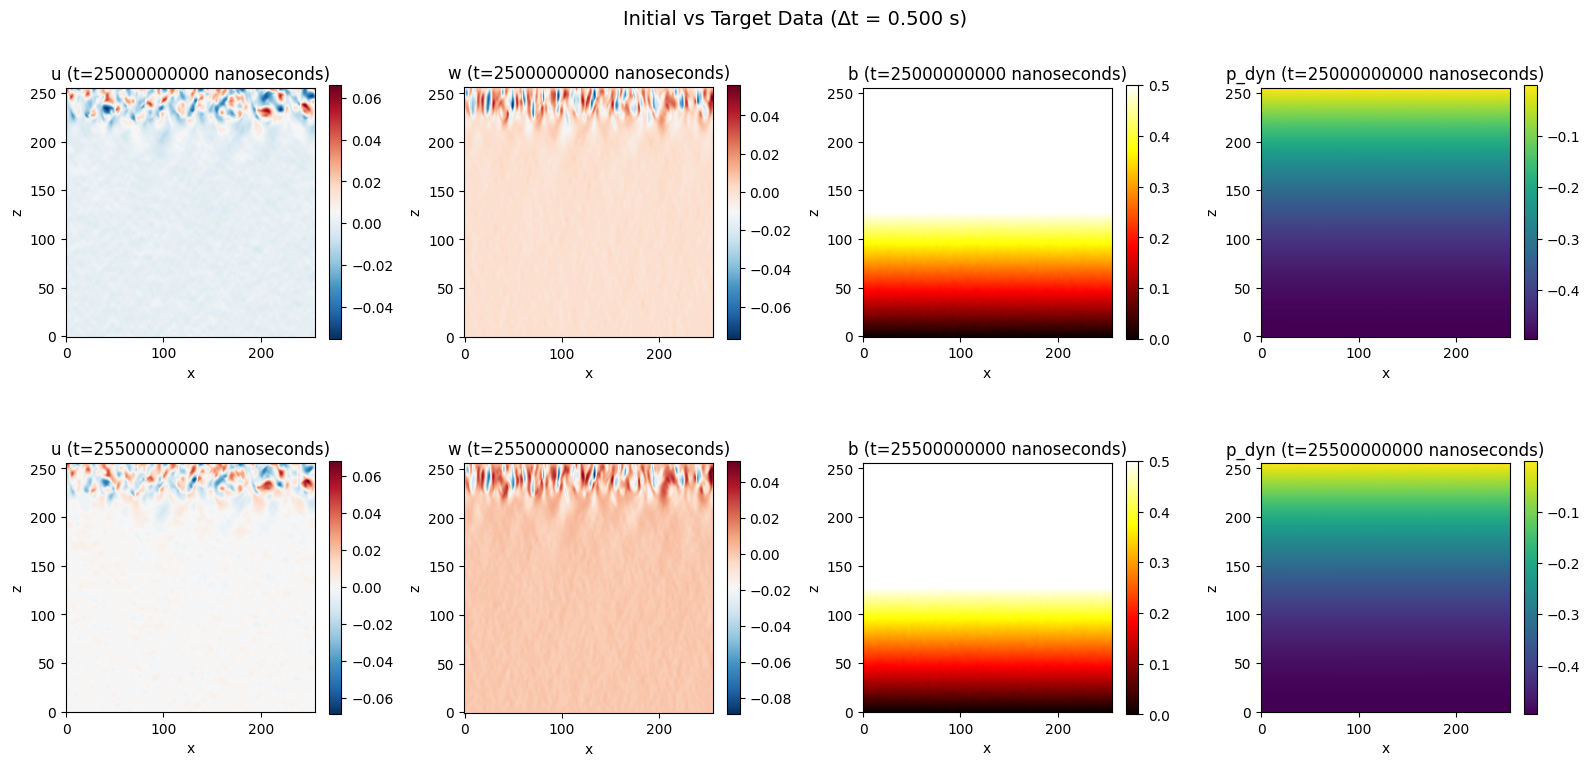


Field statistics:
Initial data:
  u: min=-0.0553, max=0.0659, mean=-0.0000
  w: min=-0.0769, max=0.0557, mean=0.0000
  b: min=0.0016, max=0.9186, mean=0.4950
  p: min=-0.4953, max=-0.0013, mean=-0.3287

Target data:
  u: min=-0.0687, max=0.0679, mean=-0.0000
  w: min=-0.0893, max=0.0516, mean=-0.0000
  b: min=0.0016, max=0.9175, mean=0.4949
  p: min=-0.4952, max=-0.0012, mean=-0.3286

Changes from initial to target:
  Δb_max: 0.089907
  Δb_mean: 0.001097


In [68]:
# Create visualization of initial and target data
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Define common colormaps
cmap_velocity = 'RdBu_r'
cmap_buoyancy = 'hot'
cmap_pressure = 'viridis'

# Plot initial data (t = t0)
im1 = axes[0, 0].imshow(u_init, aspect='equal', cmap=cmap_velocity, origin='lower')
axes[0, 0].set_title(f'u (t={X_init.time.values})', fontsize=12)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

im2 = axes[0, 1].imshow(w_init, aspect='equal', cmap=cmap_velocity, origin='lower')
axes[0, 1].set_title(f'w (t={X_init.time.values})', fontsize=12)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('z')
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

im3 = axes[0, 2].imshow(b_init, aspect='equal', cmap=cmap_buoyancy, origin='lower', vmin=0, vmax=0.5)
axes[0, 2].set_title(f'b (t={X_init.time.values})', fontsize=12)
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('z')
plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)

im4 = axes[0, 3].imshow(p_dyn_init, aspect='equal', cmap=cmap_pressure, origin='lower')
axes[0, 3].set_title(f'p_dyn (t={X_init.time.values})', fontsize=12)
axes[0, 3].set_xlabel('x')
axes[0, 3].set_ylabel('z')
plt.colorbar(im4, ax=axes[0, 3], fraction=0.046)

# Plot target data (t = t0 + dt)
u_target = X_target['u'].values
w_target = X_target['w'].values
p_dyn_target = X_target['p_dyn'].values

im5 = axes[1, 0].imshow(u_target, aspect='equal', cmap=cmap_velocity, origin='lower')
axes[1, 0].set_title(f'u (t={X_target.time.values})', fontsize=12)
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('z')
plt.colorbar(im5, ax=axes[1, 0], fraction=0.046)

im6 = axes[1, 1].imshow(w_target, aspect='equal', cmap=cmap_velocity, origin='lower')
axes[1, 1].set_title(f'w (t={X_target.time.values})', fontsize=12)
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('z')
plt.colorbar(im6, ax=axes[1, 1], fraction=0.046)

im7 = axes[1, 2].imshow(b_target, aspect='equal', cmap=cmap_buoyancy, origin='lower', vmin=0, vmax=0.5)
axes[1, 2].set_title(f'b (t={X_target.time.values})', fontsize=12)
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('z')
plt.colorbar(im7, ax=axes[1, 2], fraction=0.046)

im8 = axes[1, 3].imshow(p_dyn_target, aspect='equal', cmap=cmap_pressure, origin='lower')
axes[1, 3].set_title(f'p_dyn (t={X_target.time.values})', fontsize=12)
axes[1, 3].set_xlabel('x')
axes[1, 3].set_ylabel('z')
plt.colorbar(im8, ax=axes[1, 3], fraction=0.046)

plt.suptitle(f'Initial vs Target Data (Δt = {dt:.3f} s)', fontsize=14)
plt.tight_layout()
plt.show()

# Print statistics
print("\nField statistics:")
print("Initial data:")
print(f"  u: min={u_init.min():.4f}, max={u_init.max():.4f}, mean={u_init.mean():.4f}")
print(f"  w: min={w_init.min():.4f}, max={w_init.max():.4f}, mean={w_init.mean():.4f}")
print(f"  b: min={b_init.min():.4f}, max={b_init.max():.4f}, mean={b_init.mean():.4f}")
print(f"  p: min={p_dyn_init.min():.4f}, max={p_dyn_init.max():.4f}, mean={p_dyn_init.mean():.4f}")

print("\nTarget data:")
print(f"  u: min={u_target.min():.4f}, max={u_target.max():.4f}, mean={u_target.mean():.4f}")
print(f"  w: min={w_target.min():.4f}, max={w_target.max():.4f}, mean={w_target.mean():.4f}")
print(f"  b: min={b_target.min():.4f}, max={b_target.max():.4f}, mean={b_target.mean():.4f}")
print(f"  p: min={p_dyn_target.min():.4f}, max={p_dyn_target.max():.4f}, mean={p_dyn_target.mean():.4f}")

# Calculate and display changes
print("\nChanges from initial to target:")
print(f"  Δb_max: {np.abs(b_target - b_init).max():.6f}")
print(f"  Δb_mean: {np.abs(b_target - b_init).mean():.6f}")

In [69]:
# Normalize fields
def normalize_field(field):
    mean = np.mean(field)
    std = np.std(field)
    return (field - mean) / (std + 1e-8), mean, std

u_norm, u_mean, u_std = normalize_field(u_interp)
w_norm, w_mean, w_std = normalize_field(w_interp)
b_norm, b_mean, b_std = normalize_field(b_init)
p_norm, p_mean, p_std = normalize_field(p_dyn_init)

# Store normalization parameters for denormalization later
norm_params = {
    'b': (b_mean, b_std),
    'u': (u_mean, u_std),
    'w': (w_mean, w_std),
    'p': (p_mean, p_std)
}

print("Normalization statistics:")
for field, (mean, std) in norm_params.items():
    print(f"{field}: mean={mean:.4f}, std={std:.4f}")

Normalization statistics:
b: mean=0.4950, std=0.2810
u: mean=-0.0000, std=0.0064
w: mean=0.0000, std=0.0069
p: mean=-0.3287, std=0.1487


In [70]:
class CNNBranchNet(nn.Module):
    """6-layer CNN for processing spatial fields"""
    def __init__(self, in_channels=4, hidden_dim=64, out_dim=128):
        super(CNNBranchNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim*2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_dim*2)
        
        self.conv3 = nn.Conv2d(hidden_dim*2, hidden_dim*2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(hidden_dim*2)
        
        self.conv4 = nn.Conv2d(hidden_dim*2, hidden_dim*4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(hidden_dim*4)
        
        self.conv5 = nn.Conv2d(hidden_dim*4, hidden_dim*4, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(hidden_dim*4)
        
        self.conv6 = nn.Conv2d(hidden_dim*4, out_dim, 3, padding=1)
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.activation(self.bn4(self.conv4(x)))
        x = self.activation(self.bn5(self.conv5(x)))
        x = self.conv6(x)
        x = self.pool(x)
        return x.squeeze(-1).squeeze(-1)

class MLPTrunkNet(nn.Module):
    """6-layer MLP for processing time"""
    def __init__(self, in_dim=1, hidden_dim=64, out_dim=128):
        super(MLPTrunkNet, self).__init__()
        
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.fc4 = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.fc5 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, out_dim)
        
        self.activation = nn.ReLU()
        
    def forward(self, t):
        t = self.activation(self.fc1(t))
        t = self.activation(self.fc2(t))
        t = self.activation(self.fc3(t))
        t = self.activation(self.fc4(t))
        t = self.activation(self.fc5(t))
        t = self.fc6(t)
        return t

class HybridDeepONet(nn.Module):
    """Hybrid DeepONet for buoyancy prediction"""
    def __init__(self, branch_dim=128, trunk_dim=128, grid_size=256):
        super(HybridDeepONet, self).__init__()
        
        self.branch_net = CNNBranchNet(in_channels=4, out_dim=branch_dim)
        self.trunk_net = MLPTrunkNet(in_dim=1, out_dim=trunk_dim)
        
        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(branch_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(2048, grid_size * grid_size)
        )
        
        self.grid_size = grid_size
        
    def forward(self, spatial_fields, delta_t):
        # Branch network output
        branch_out = self.branch_net(spatial_fields)
        
        # Trunk network output
        trunk_out = self.trunk_net(delta_t)
        
        # Combine via element-wise multiplication
        combined = branch_out * trunk_out
        
        # Decode to spatial field
        b_pred = self.decoder(combined)
        b_pred = b_pred.view(-1, self.grid_size, self.grid_size)
        
        return b_pred

In [71]:
def compute_derivatives(field, dx, dz):
    """Compute spatial derivatives using finite differences"""
    # Ensure correct dimensions
    if field.dim() == 2:
        field = field.unsqueeze(0)
    
    batch_size = field.shape[0]
    
    # x-derivatives (periodic boundary)
    df_dx = torch.zeros_like(field)
    df_dx[:, :, 1:-1] = (field[:, :, 2:] - field[:, :, :-2]) / (2 * dx)
    df_dx[:, :, 0] = (field[:, :, 1] - field[:, :, -1]) / (2 * dx)  # periodic
    df_dx[:, :, -1] = (field[:, :, 0] - field[:, :, -2]) / (2 * dx)  # periodic
    
    # z-derivatives (bounded)
    df_dz = torch.zeros_like(field)
    df_dz[:, 1:-1, :] = (field[:, 2:, :] - field[:, :-2, :]) / (2 * dz)
    df_dz[:, 0, :] = (field[:, 1, :] - field[:, 0, :]) / dz  # forward diff at bottom
    df_dz[:, -1, :] = (field[:, -1, :] - field[:, -2, :]) / dz  # backward diff at top
    
    return df_dx, df_dz

def physics_loss(b_pred, u, w, b_init, dx, dz, dt, kappa):
    """
    Physics loss based on buoyancy advection-diffusion equation:
    ∂b/∂t + u·∇b = κ∇²b
    """
    # Compute derivatives
    db_dx, db_dz = compute_derivatives(b_pred, dx, dz)
    
    # Second derivatives for diffusion
    d2b_dx2, _ = compute_derivatives(db_dx, dx, dz)
    _, d2b_dz2 = compute_derivatives(db_dz, dx, dz)
    
    # Time derivative
    db_dt = (b_pred - b_init) / dt
    
    # Advection term
    advection = u * db_dx + w * db_dz
    
    # Diffusion term
    diffusion = kappa * (d2b_dx2 + d2b_dz2)
    
    # Physics residual
    residual = db_dt + advection - diffusion
    
    return torch.mean(residual**2)

def boundary_condition_loss(b_pred):
    """
    Boundary conditions:
    - Top (z=0): b = 0.5
    - Bottom (z=-1): b = 0
    """
    top_bc = torch.mean((b_pred[:, -1, :] - 0.5)**2)
    bottom_bc = torch.mean((b_pred[:, 0, :])**2)
    
    return top_bc + bottom_bc

def initial_condition_loss(b_pred, b_init):
    """Ensure smooth transition from initial condition"""
    return torch.mean((b_pred - b_init)**2)

def smoothness_loss(b_pred):
    """Spatial smoothness regularization"""
    # Total variation regularization
    tv_z = torch.mean(torch.abs(b_pred[:, 1:, :] - b_pred[:, :-1, :]))
    tv_x = torch.mean(torch.abs(b_pred[:, :, 1:] - b_pred[:, :, :-1]))
    
    return tv_z + tv_x

def incompressibility_loss(u, w, dx, dz):
    """Incompressibility constraint: ∇·u = 0"""
    du_dx, _ = compute_derivatives(u, dx, dz)
    _, dw_dz = compute_derivatives(w, dx, dz)
    
    div_u = du_dx + dw_dz
    
    return torch.mean(div_u**2)

In [72]:
# Stack input fields
input_fields = np.stack([u_norm, w_norm, p_norm, b_norm], axis=0)
input_tensor = torch.FloatTensor(input_fields).unsqueeze(0).to(device)

# Time tensor
dt_tensor = torch.FloatTensor([[dt]]).to(device)

# Initial condition tensors
b_init_tensor = torch.FloatTensor(b_norm).unsqueeze(0).to(device)
u_tensor = torch.FloatTensor(u_norm).unsqueeze(0).to(device)
w_tensor = torch.FloatTensor(w_norm).unsqueeze(0).to(device)

# Grid spacing
x_coords = X_init.x_caa.values
z_coords = X_init.z_aac.values
dx = float(x_coords[1] - x_coords[0])
dz = float(z_coords[1] - z_coords[0])

# Physical parameters
kappa = 1e-6  # thermal diffusivity (κ = ν/Pr, and Pr=1)

print(f"Grid spacing: dx={dx:.6f}, dz={dz:.6f}")
print(f"Thermal diffusivity: κ={kappa}")

Grid spacing: dx=0.007812, dz=0.003906
Thermal diffusivity: κ=1e-06


In [73]:
# Initialize model
model = HybridDeepONet(branch_dim=128, trunk_dim=128, grid_size=256).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, verbose=True)

# Loss weights
loss_weights = {
    'physics': 1.0,
    'bc': 10.0,
    'ic': 0.1,
    'smooth': 0.01,
    'incomp': 0.1
}

print("\nLoss weights:")
for key, value in loss_weights.items():
    print(f"{key}: {value}")

Total parameters: 136,863,744

Loss weights:
physics: 1.0
bc: 10.0
ic: 0.1
smooth: 0.01
incomp: 0.1


c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [74]:
# Training parameters
n_epochs = 2000
print_interval = 500

# Training history
history = {
    'total_loss': [],
    'physics_loss': [],
    'bc_loss': [],
    'ic_loss': [],
    'smooth_loss': [],
    'incomp_loss': []
}

# Training loop
model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    b_pred = model(input_tensor, dt_tensor)
    
    # Compute individual losses
    l_physics = physics_loss(b_pred, u_tensor, w_tensor, b_init_tensor, dx, dz, dt, kappa)
    l_bc = boundary_condition_loss(b_pred)
    l_ic = initial_condition_loss(b_pred, b_init_tensor)
    l_smooth = smoothness_loss(b_pred)
    l_incomp = incompressibility_loss(u_tensor, w_tensor, dx, dz)
    
    # Total loss
    total_loss = (loss_weights['physics'] * l_physics + 
                  loss_weights['bc'] * l_bc + 
                  loss_weights['ic'] * l_ic + 
                  loss_weights['smooth'] * l_smooth +
                  loss_weights['incomp'] * l_incomp)
    
    # Backward pass
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    # # Record history
    # history['total_loss'].append(total_loss.item())
    # history['physics_loss'].append(l_physics.item())
    # history['bc_loss'].append(l_bc.item())
    # history['ic_loss'].append(l_ic.item())
    # history['smooth_loss'].append(l_smooth.item())
    # history['incomp_loss'].append(l_incomp.item())
    
    # Learning rate scheduling
    scheduler.step(total_loss)
    
    if (epoch) % print_interval == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Total: {total_loss.item():.6f} | Physics: {l_physics.item():.6f} | BC: {l_bc.item():.6f} | IC: {l_ic.item():.6f} | Smooth: {l_smooth.item():.6f} | Incomp: {l_incomp.item():.6f}")


Epoch 1/2000 | Total: 59.409660 | Physics: 18.688103 | BC: 0.251123 | IC: 1.000431 | Smooth: 0.042328 | Incomp: 381.098572


KeyboardInterrupt: 

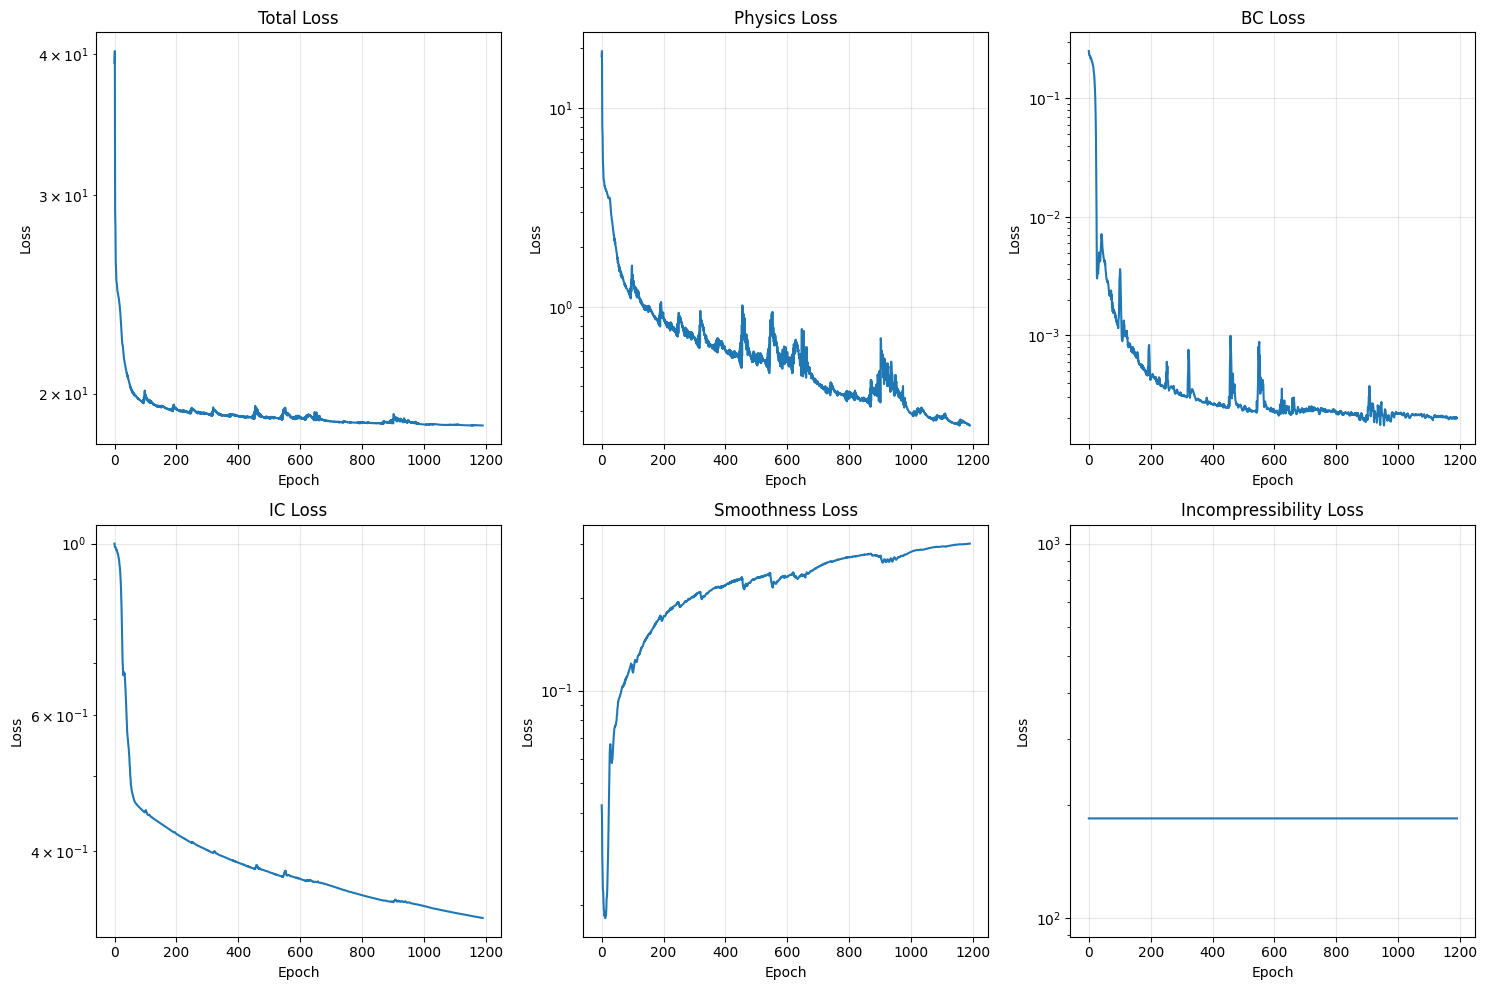

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

loss_names = ['total_loss', 'physics_loss', 'bc_loss', 'ic_loss', 'smooth_loss', 'incomp_loss']
loss_titles = ['Total Loss', 'Physics Loss', 'BC Loss', 'IC Loss', 'Smoothness Loss', 'Incompressibility Loss']

for idx, (loss_name, title) in enumerate(zip(loss_names, loss_titles)):
    ax = axes[idx]
    ax.semilogy(history[loss_name])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Make prediction
model.eval()
with torch.no_grad():
    b_pred_norm = model(input_tensor, dt_tensor)
    b_pred_norm = b_pred_norm.squeeze().cpu().numpy()

# Denormalize prediction
b_pred = b_pred_norm * b_std + b_mean

# Also denormalize the target for comparison
b_target_denorm = b_target

print(f"Prediction shape: {b_pred.shape}")
print(f"Prediction range: [{b_pred.min():.4f}, {b_pred.max():.4f}]")
print(f"Target range: [{b_target_denorm.min():.4f}, {b_target_denorm.max():.4f}]")

Prediction shape: (256, 256)
Prediction range: [-0.5615, 1.5287]
Target range: [0.0017, 0.8843]


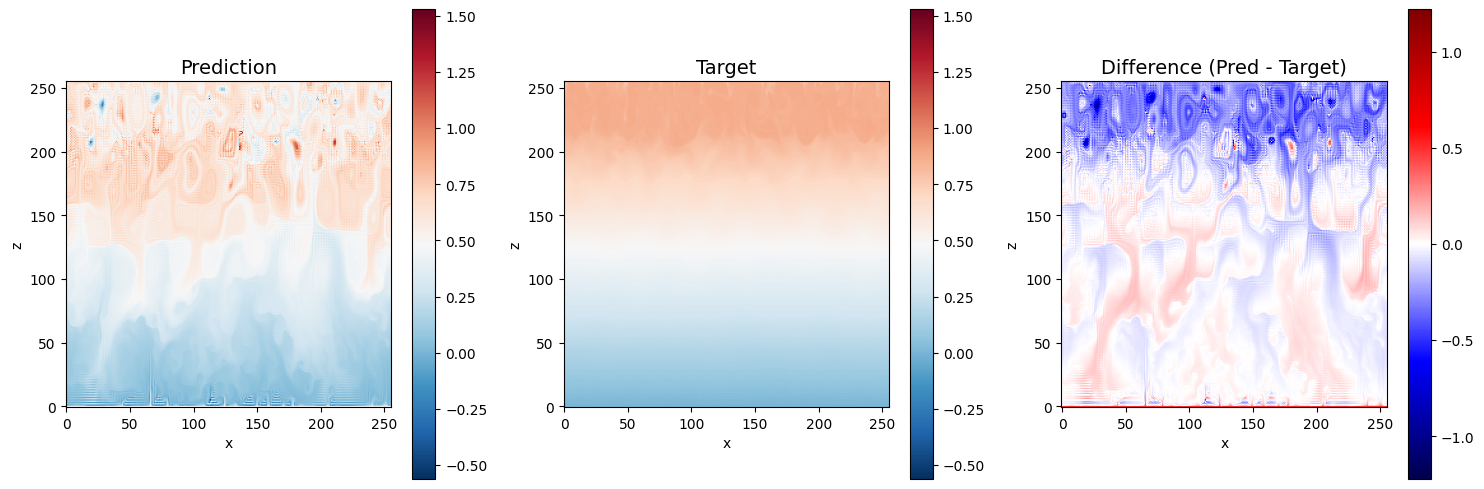


Error Metrics:
MSE: 0.024697
MAE: 0.102967
Relative Error: 136.3588%


In [ ]:
# Create side-by-side comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Common colorbar limits
vmin = min(b_pred.min(), b_target_denorm.min())
vmax = max(b_pred.max(), b_target_denorm.max())

# Plot prediction
im1 = axes[0].imshow(b_pred, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
axes[0].set_title('Prediction', fontsize=14)
axes[0].set_xlabel('x')
axes[0].set_ylabel('z')
plt.colorbar(im1, ax=axes[0])

# Plot target
im2 = axes[1].imshow(b_target_denorm, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
axes[1].set_title('Target', fontsize=14)
axes[1].set_xlabel('x')
axes[1].set_ylabel('z')
plt.colorbar(im2, ax=axes[1])

# Plot difference
diff = b_pred - b_target_denorm
im3 = axes[2].imshow(diff, aspect='equal', cmap='seismic', vmin=-np.abs(diff).max(), vmax=np.abs(diff).max(), origin='lower')
axes[2].set_title('Difference (Pred - Target)', fontsize=14)
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

# Calculate error metrics
mse = np.mean((b_pred - b_target_denorm)**2)
mae = np.mean(np.abs(b_pred - b_target_denorm))
relative_error = np.mean(np.abs(b_pred - b_target_denorm) / (np.abs(b_target_denorm) + 1e-8))

print(f"\nError Metrics:")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Relative Error: {relative_error:.4%}")

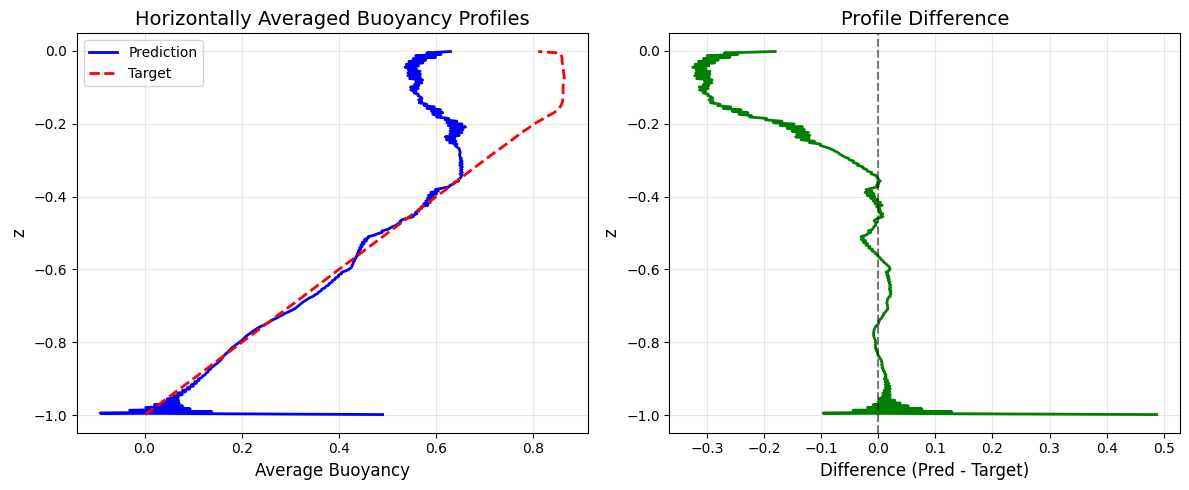


Profile Error Metrics:
Profile MSE: 0.018288
Profile MAE: 0.077958


In [ ]:
# Calculate horizontally averaged buoyancy profiles
avg_b_pred = np.mean(b_pred, axis=1)  # Average along x
avg_b_target = np.mean(b_target_denorm, axis=1)  # Average along x

# Create the comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Overlapped profiles
ax1.plot(avg_b_pred, z_coords, 'b-', linewidth=2, label='Prediction')
ax1.plot(avg_b_target, z_coords, 'r--', linewidth=2, label='Target')
ax1.set_xlabel('Average Buoyancy', fontsize=12)
ax1.set_ylabel('z', fontsize=12)
ax1.set_title('Horizontally Averaged Buoyancy Profiles', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Profile difference
profile_diff = avg_b_pred - avg_b_target
ax2.plot(profile_diff, z_coords, 'g-', linewidth=2)
ax2.axvline(x=0, color='k', linestyle='--', alpha=0.5)
ax2.set_xlabel('Difference (Pred - Target)', fontsize=12)
ax2.set_ylabel('z', fontsize=12)
ax2.set_title('Profile Difference', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate profile error metrics
profile_mse = np.mean((avg_b_pred - avg_b_target)**2)
profile_mae = np.mean(np.abs(avg_b_pred - avg_b_target))

print(f"\nProfile Error Metrics:")
print(f"Profile MSE: {profile_mse:.6f}")
print(f"Profile MAE: {profile_mae:.6f}")

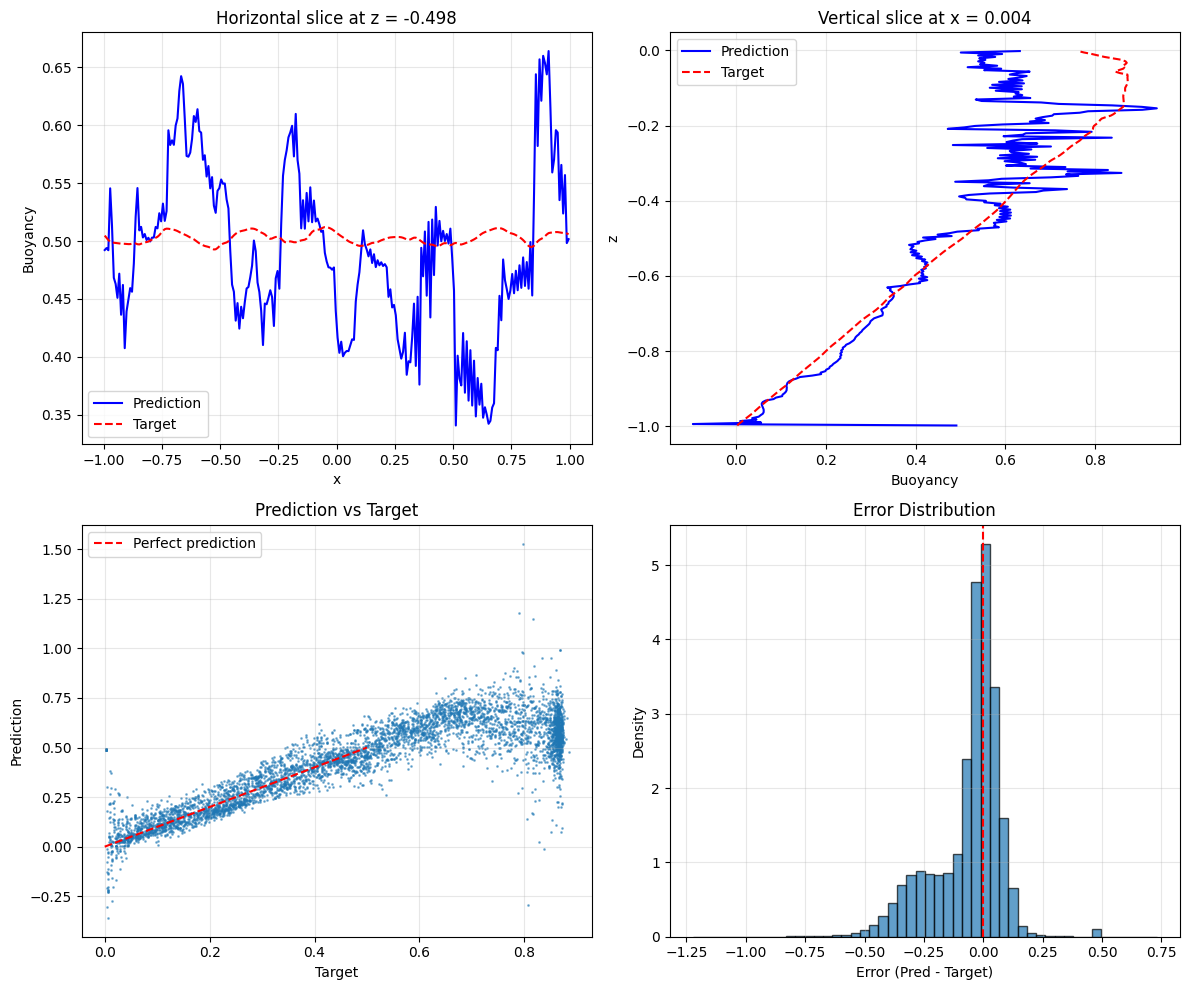

In [ ]:
# Create a more detailed analysis figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Horizontal slice at mid-height
mid_z_idx = len(z_coords) // 2
ax = axes[0, 0]
ax.plot(x_coords, b_pred[mid_z_idx, :], 'b-', label='Prediction')
ax.plot(x_coords, b_target_denorm[mid_z_idx, :], 'r--', label='Target')
ax.set_xlabel('x')
ax.set_ylabel('Buoyancy')
ax.set_title(f'Horizontal slice at z = {z_coords[mid_z_idx]:.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Vertical slice at center
mid_x_idx = len(x_coords) // 2
ax = axes[0, 1]
ax.plot(b_pred[:, mid_x_idx], z_coords, 'b-', label='Prediction')
ax.plot(b_target_denorm[:, mid_x_idx], z_coords, 'r--', label='Target')
ax.set_xlabel('Buoyancy')
ax.set_ylabel('z')
ax.set_title(f'Vertical slice at x = {x_coords[mid_x_idx]:.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Scatter plot: Prediction vs Target
ax = axes[1, 0]
sample_indices = np.random.choice(b_pred.size, 5000, replace=False)
ax.scatter(b_target_denorm.flatten()[sample_indices], 
           b_pred.flatten()[sample_indices], 
           alpha=0.5, s=1)
ax.plot([0, 0.5], [0, 0.5], 'r--', label='Perfect prediction')
ax.set_xlabel('Target')
ax.set_ylabel('Prediction')
ax.set_title('Prediction vs Target')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Error distribution
ax = axes[1, 1]
errors = (b_pred - b_target_denorm).flatten()
ax.hist(errors, bins=50, density=True, alpha=0.7, edgecolor='black')
ax.set_xlabel('Error (Pred - Target)')
ax.set_ylabel('Density')
ax.set_title('Error Distribution')
ax.axvline(x=0, color='r', linestyle='--', label='Zero error')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()